<a href="https://colab.research.google.com/github/Christianib003/water-quality-model/blob/Irenee/Irenee_water_quality_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FORMATIVE ASSIGNMENT II: WATER QUALITY MODEL

## 1. Introduction
**Assignment**: Building a Classification Model Using Neural Networks

**Objective:**
Develop a neural network-based classification model using a provided dataset, incorporating multiple optimization techniques and ensuring equitable group contribution.

**In this notebook, we will take the cleaned and imputed dataset and use it to train, test, and evaluate a deep learning model**:

The key steps we'll cover are:
1. Loading the preprocessed (imputed) dataset.
2. Separating features and the target variable.
3. Splitting the dataset into three distinct portions: training, validation, and testing sets. This is crucial for robust model development and evaluation.
4. Applying feature scaling (StandardScaler) correctly after the split to prevent data leakage.

**Note:** The data cleaning and imputation steps were performed in a previous notebook.
If you'd like to review that process, please refer to: [Data Preprocessing Notebook](data_preprocessing.ipynb).

**Model Details**


| Engineer Name     | Regularizer | Optimizer | Early Stopping  | Dropout Rate | Learning Rate |
| ----------------- | ---------------------------- | --------- | ------------------------------------------------ | ------------ | ------------- |
| Irenee Dusingizimana | L2           | AdamW      | Patience=10                 | 0.01        | 0.0001       |



In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. Feature Scaling
### 2.1 Declaring Utility Functions

In [37]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.optimizers import AdamW
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

In [38]:
def load_data(file_path: str) -> pd.DataFrame:
    """
    Loads a CSV file into a pandas DataFrame.

    Args:
        file_path (str): The path to the CSV file.

    Returns:
        pd.DataFrame: The loaded DataFrame.

    Raises:
        TypeError: If file_path is not a string.
        FileNotFoundError: If the file specified by file_path is not found.
        Exception: For other pandas-related read errors.
    """
    if not isinstance(file_path, str):
        raise TypeError("file_path must be a string.")
    try:
        df = pd.read_csv(file_path)
        print(f"Successfully loaded dataset from: {file_path}")
        return df
    except FileNotFoundError:
        raise FileNotFoundError(f"Error: The file '{file_path}' was not found.")
    except Exception as e:
        raise Exception(f"Error reading CSV file '{file_path}': {e}")

In [39]:
# Display the first few rows of the dataset
# We verify the columns, data types, and ensure that our imputation worked
# All columns should have non-null counts matching the total number of entries.
def display_initial_info(df: pd.DataFrame):
    """
    Displays the first few rows and basic info of a DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame to inspect.

    Raises:
        TypeError: If df is not a pandas DataFrame.
        ValueError: If df is None.
    """
    print("===============First 5 rows:===============")
    print(df.head())
    print("\n===============Information:===============")
    df.info()

In [40]:
def separate_features_target(df: pd.DataFrame, target_column: str) -> tuple[pd.DataFrame, pd.Series]:
    """
    Separates features and the target variable from a DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame to separate.
        target_column (str): The name of the target column.

    Returns:
        tuple[pd.DataFrame, pd.Series]: A tuple containing features (X) and target (y).

    Raises:
        TypeError: If df is not a DataFrame or target_column is not a string.
        ValueError: If df is None or target_column is not found in df.columns.
    """
    if target_column not in df.columns:
        raise ValueError(f"Target column '{target_column}' not found in DataFrame columns: {df.columns.tolist()}")

    X = df.drop(columns=[target_column])
    y = df[target_column]
    print(f"\nFeatures (X) and target (y, column: '{target_column}') have been separated.")
    print(f"Shape of features (X): {X.shape}")
    print(f"Shape of target (y): {y.shape}")
    return X, y


In [41]:
def split_data(X: pd.DataFrame, y: pd.Series,
               test_size: float = 0.15,
               val_relative_to_train_val_size: float = 0.15 / 0.85,
               random_state: int = 42,
               stratify_data: bool = True) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.Series, pd.Series, pd.Series]:
    """
    Splits feature and target data into training, validation, and test sets.

    Args:
        X (pd.DataFrame): Features.
        y (pd.Series): Target variable.
        test_size (float): Proportion of the dataset to allocate to the test set.
        val_relative_to_train_val_size (float): Proportion of the (train+validation) set to allocate to validation.
        random_state (int): Seed for random number generator for reproducibility.
        stratify_data (bool): Whether to stratify the split based on the target variable y.

    Returns:
        tuple: X_train, X_val, X_test, y_train, y_val, y_test

    Raises:
        TypeError: If X is not a DataFrame or y is not a Series.
        ValueError: If X or y is None, or if shapes are incompatible.
    """
    if len(X) != len(y):
        raise ValueError(f"Shape mismatch: X has {len(X)} samples, y has {len(y)} samples.")

    stratify_option_main = y if stratify_data else None
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=stratify_option_main
    )

    stratify_option_tv = y_train_val if stratify_data else None
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_relative_to_train_val_size,
        random_state=random_state, stratify=stratify_option_tv
    )

    print("\nData splitting completed.")
    return X_train, X_val, X_test, y_train, y_val, y_test

In [42]:
def scale_features(X_train: pd.DataFrame, X_val: pd.DataFrame, X_test: pd.DataFrame) -> tuple[StandardScaler, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Fits StandardScaler on X_train and transforms X_train, X_val, X_test.

    Args:
        X_train (pd.DataFrame): Training features.
        X_val (pd.DataFrame): Validation features.
        X_test (pd.DataFrame): Test features.

    Returns:
        tuple: The fitted scaler object, and the scaled DataFrames (X_train_scaled, X_val_scaled, X_test_scaled).

    Raises:
        TypeError: If any input is not a pandas DataFrame.
        ValueError: If any input DataFrame is None.
    """
    for df_name, df_obj in [("X_train", X_train), ("X_val", X_val), ("X_test", X_test)]:
        if not isinstance(df_obj, pd.DataFrame):
            raise TypeError(f"Input '{df_name}' must be a pandas DataFrame. Got {type(df_obj)}.")
        if df_obj is None:
            raise ValueError(f"Input DataFrame '{df_name}' cannot be None.")

    scaler = StandardScaler()

    print("\nFitting StandardScaler on X_train...")
    # Ensure X_train has data (not empty) before fitting
    if X_train.empty:
        raise ValueError("X_train is empty, cannot fit StandardScaler.")
    scaler.fit(X_train) # Fit ONLY on training data
    print("Scaler fitted.")

    print("Transforming X_train, X_val, and X_test...")
    X_train_scaled_array = scaler.transform(X_train)
    X_val_scaled_array = scaler.transform(X_val)
    X_test_scaled_array = scaler.transform(X_test)
    print("Transformation complete.")

    # Convert back to DataFrames
    X_train_scaled = pd.DataFrame(X_train_scaled_array, columns=X_train.columns, index=X_train.index)
    X_val_scaled = pd.DataFrame(X_val_scaled_array, columns=X_val.columns, index=X_val.index)
    X_test_scaled = pd.DataFrame(X_test_scaled_array, columns=X_test.columns, index=X_test.index)
    print("Scaled data converted back to DataFrames.")

    return scaler, X_train_scaled, X_val_scaled, X_test_scaled



### 2.2 Feature Scaling Implementation

In [43]:
# Here, we load the dataset that has already undergone cleaning and imputation.
# It's important to use the version where missing values have already been handled.
# Path to the file which has already missing fields handled
FILE_PATH_IMPUTED = "../data/imputed_water_potability_data.csv"

# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/imputed_water_potability_data.csv')
data.head()

# Display the overview of the dataset
display_initial_info(data)

===============First 5 rows:===============
         ph    Hardness        Solids  Chloramines     Sulfate  Conductivity  \
0  7.036752  204.890455  20791.318981     7.300212  368.516441    564.308654   
1  3.716080  129.422921  18630.057858     6.635246  333.073546    592.885359   
2  8.099124  224.236259  19909.541732     9.275884  333.073546    418.606213   
3  8.316766  214.373394  22018.417441     8.059332  356.886136    363.266516   
4  9.092223  181.101509  17978.986339     6.546600  310.135738    398.410813   

   Organic_carbon  Trihalomethanes  Turbidity  Potability  
0       10.379783        86.990970   2.963135           0  
1       15.180013        56.329076   4.500656           0  
2       16.868637        66.420093   3.055934           0  
3       18.436524       100.341674   4.628771           0  
4       11.558279        31.997993   4.075075           0  

===============Information:===============
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 32

In [44]:
# Separate features and target variable
X, y = separate_features_target(data, "Potability")


Features (X) and target (y, column: 'Potability') have been separated.
Shape of features (X): (3276, 9)
Shape of target (y): (3276,)


In [45]:
# Initialize split variables to None
X_train, X_val, X_test, y_train, y_val, y_test = [None] * 6

if X is not None and y is not None:
    try:
        X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y, stratify_data=True)

        # Display proportions
        print(f"Shape of X_train: {X_train.shape}, y_train: {y_train.shape}")
        print(f"Shape of X_val: {X_val.shape}, y_val: {y_val.shape}")
        print(f"Shape of X_test: {X_test.shape}, y_test: {y_test.shape}")

        total_samples = len(X)
        print("\nProportion of samples in each set (approximate):")
        print(f"Training set: {len(X_train)/total_samples*100:.2f}%")
        print(f"Validation set: {len(X_val)/total_samples*100:.2f}%")
        print(f"Test set: {len(X_test)/total_samples*100:.2f}%")

    except TypeError as e:
        raise ValueError(f"TypeError during data splitting: {e}")
    except ValueError as e:
        raise ValueError(f"ValueError during data splitting: {e}")
else:
    raise ValueError("X or y is None.")


Data splitting completed.
Shape of X_train: (2292, 9), y_train: (2292,)
Shape of X_val: (492, 9), y_val: (492,)
Shape of X_test: (492, 9), y_test: (492,)

Proportion of samples in each set (approximate):
Training set: 69.96%
Validation set: 15.02%
Test set: 15.02%


In [46]:
scaler_object, X_train_scaled, X_val_scaled, X_test_scaled = [None] * 4

if X_train is not None and X_val is not None and X_test is not None:
    try:
        scaler_object, X_train_scaled, X_val_scaled, X_test_scaled = scale_features(X_train, X_val, X_test)

        print("\n--- Verification of Scaled Training Data ---")
        display_initial_info(X_train_scaled)

        print("\nDescriptive statistics of X_train_scaled (mean ~0, std ~1):")
        print(X_train_scaled.describe().round(2))

        print("\nWorkflow complete. Data is prepared for model training.")
        print("Prepared data sets:")
        print(f"X_train_scaled: {X_train_scaled.shape}, y_train: {y_train.shape if y_train is not None else 'N/A'}")
        print(f"X_val_scaled: {X_val_scaled.shape}, y_val: {y_val.shape if y_val is not None else 'N/A'}")
        print(f"X_test_scaled: {X_test_scaled.shape}, y_test: {y_test.shape if y_test is not None else 'N/A'}")

    except (TypeError, ValueError) as e:
        print(f"Error during feature scaling: {e}")
else:
    print("Skipping feature scaling as data splits are not available.")


Fitting StandardScaler on X_train...
Scaler fitted.
Transforming X_train, X_val, and X_test...
Transformation complete.
Scaled data converted back to DataFrames.

--- Verification of Scaled Training Data ---
===============First 5 rows:===============
            ph  Hardness    Solids  Chloramines   Sulfate  Conductivity  \
2766  0.292120  0.027566  0.522327     0.038376 -1.781081     -0.634797   
2505 -0.104021  0.816164 -0.481655     0.540023 -0.954435      0.033630   
163  -0.647064 -1.665957 -1.420733     0.308547 -1.555323     -0.140706   
43    1.961394  0.193955 -1.379953    -0.160524  0.108557     -1.163968   
2040 -0.022284  1.805507 -0.796542     0.846080  0.798238      0.565539   

      Organic_carbon  Trihalomethanes  Turbidity  
2766       -0.341967         0.209553  -0.180315  
2505       -0.619904         0.161566  -1.631684  
163         0.672902        -0.993148   0.866453  
43          2.973166         0.352298   0.939613  
2040        0.099535        -1.655482  -0

## 3. Building and Training a Model

...

### Defining Model

In [47]:
# Define the model
model = Sequential()
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape=(X.shape[1],)))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)))

model.add(Dense(1, activation='sigmoid'))


# Compile with AdamW optimizer
optimizer = AdamW(learning_rate=0.0001)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [48]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,753 (10.75 KB)

 Trainable params: 2,753 (10.75 KB)

 Non-trainable params: 0 (0.00 B)

### Training process

In [49]:
# Define Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.5724 - loss: 209.2225 - precision_1: 0.4085 - recall_1: 0.3082 - val_accuracy: 0.4641 - val_loss: 15.8804 - val_precision_1: 0.4106 - val_recall_1: 0.6458
Epoch 2/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5205 - loss: 202.1081 - precision_1: 0.3777 - recall_1: 0.3935 - val_accuracy: 0.4532 - val_loss: 18.1945 - val_precision_1: 0.4109 - val_recall_1: 0.7083
Epoch 3/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5254 - loss: 193.1433 - precision_1: 0.3701 - recall_1: 0.3933 - val_accuracy: 0.5643 - val_loss: 10.3026 - val_precision_1: 0.4474 - val_recall_1: 0.1771
Epoch 4/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5553 - loss: 168.2861 - precision_1: 0.4218 - recall_1: 0.4181 - val_accuracy: 0.5817 - val_loss: 27.5784 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 5/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5391 - loss: 158.4557 - precision_1: 0.3854 - 

Test Loss: 6.3301
Test Accuracy: 0.5630
Test Precision: 0.4286
Test Recall: 0.3594


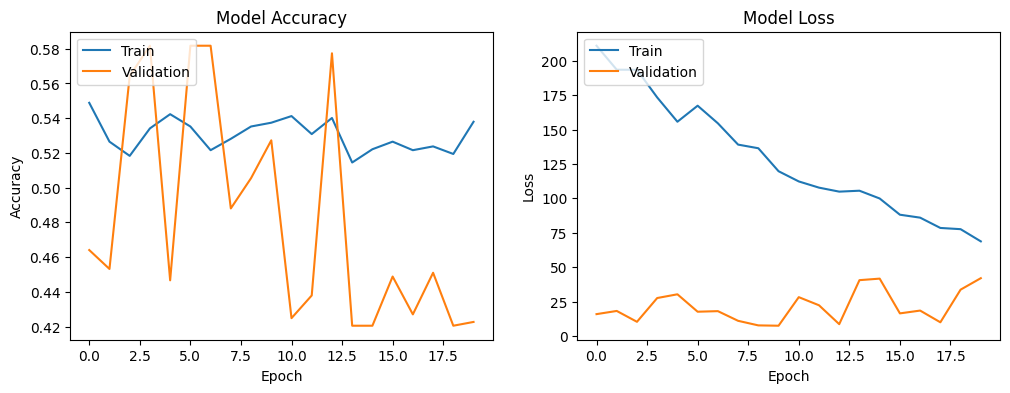

In [50]:
#  Evaluate the model with all returned metrics
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")


# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


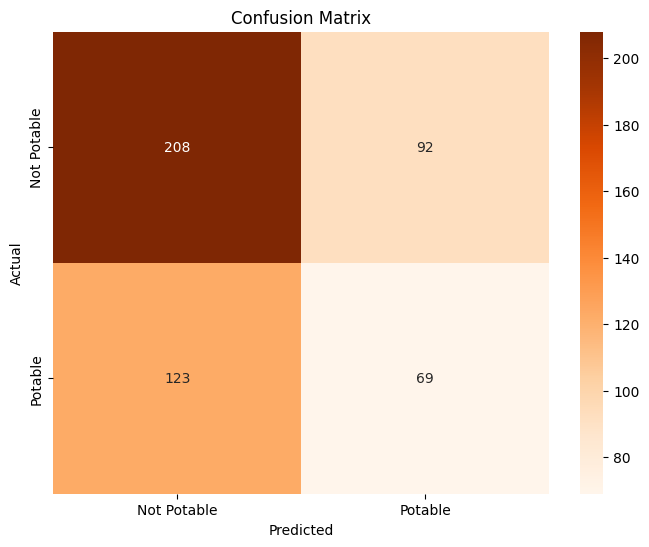


Classification Report:
              precision    recall  f1-score   support

 Not Potable       0.63      0.69      0.66       300
     Potable       0.43      0.36      0.39       192

    accuracy                           0.56       492
   macro avg       0.53      0.53      0.53       492
weighted avg       0.55      0.56      0.55       492



In [51]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Get predictions
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=['Not Potable', 'Potable'], yticklabels=['Not Potable', 'Potable'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Potable', 'Potable']))

In [55]:
    # Calculate Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    print(f"Test Accuracy:  {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall:    {recall:.4f}")
    print(f"Test F1 Score:  {f1:.4f}")

    # Display Classification Report
    print("\nClassification Report:")
    # The report provides a breakdown of precision, recall, and f1-score for each class.
    print(classification_report(y_test, y_pred, zero_division=0))

Test Accuracy:  0.5630
Test Precision: 0.4286
Test Recall:    0.3594
Test F1 Score:  0.3909

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.69      0.66       300
           1       0.43      0.36      0.39       192

    accuracy                           0.56       492
   macro avg       0.53      0.53      0.53       492
weighted avg       0.55      0.56      0.55       492

